# Part 0: Data Preparation

In [3]:
! pip install xgboost

  Using cached xgboost-1.1.1-py3-none-macosx_10_13_x86_64.macosx_10_14_x86_64.macosx_10_15_x86_64.whl (1.1 MB)


In [171]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import scipy.stats as stats
from scipy.stats import chi2_contingency
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn import metrics
import statistics
import math
import xgboost as xgb
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [6]:
df_apple = pd.read_excel('Airings-Report-Apple.xlsx'
                         , header=1, sheet_name='Brand Campaign Details')
df_samsung = pd.read_excel('Airings-Report-Samsung.xlsx'
                        , header=1, sheet_name='Brand Campaign Details')
df = pd.concat([df_apple, df_samsung])
df = df.reset_index(drop=True)

In [7]:
df.shape

(16811, 23)

In [8]:
df.tail()

,Id,Title,Brand,Product,Category,Network,Network Type,Show,Date,Time,...,Co-Op Product,Duration,EQ Units,Spend ($),Broadcast Year,Broadcast Month,Broadcast Week,Day Of Week,Hour Of Day,TimeZone
16806,4063180,Samsung Galaxy,Samsung,Samsung Galaxy,Electronics & Communication,FOX News Channel,cable,FOX and Friends,12/03/2019,7:16:42 AM,...,NaN,30,1.0,3491,2019,DEC,49,2,7,US/Eastern
16807,4063180,Samsung Galaxy,Samsung,Samsung Galaxy,Electronics & Communication,NBC,broadcast,Late Night With Seth Meyers,12/06/2019,1:27:27 AM,...,NaN,30,1.0,5257,2019,DEC,49,5,1,US/Eastern
16808,3861210,Samsung Galaxy Note 10,Samsung,Samsung Galaxy Note 10,Cell Phones,E!,cable,It's a Wonderful Life,12/25/2019,7:09:21 AM,...,NaN,30,1.0,2122,2019,DEC,52,3,7,US/Eastern
16809,3618599,Samsung Galaxy S10,Samsung,Samsung Galaxy S10,Cell Phones,FOX Sports 2,cable,FS1 College Football Playoff Preview,12/23/2019,11:41:32 PM,...,NaN,30,1.0,32,2019,DEC,52,1,23,US/Eastern
16810,3861210,Samsung Galaxy Note 10,Samsung,Samsung Galaxy Note 10,Cell Phones,CBS,broadcast,Carol's Second Act,12/25/2019,9:53:06 PM,...,NaN,30,1.0,109063,2019,DEC,52,3,21,US/Eastern


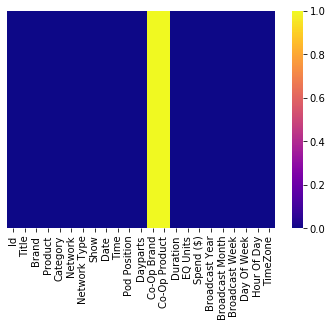

In [9]:
sns.heatmap(df.isnull(),yticklabels=False, cmap='plasma')

In [10]:
# Dropped those columns since all of there values are NaN
df.drop(columns=['Co-Op Brand','Co-Op Product'], inplace=True)

In [11]:
spend = df.pop('Spend ($)')
df['Cost']=spend 

In [12]:
df.columns

Index(['Id', 'Title', 'Brand', 'Product', 'Category', 'Network',
       'Network Type', 'Show', 'Date', 'Time', 'Pod Position', 'Dayparts',
       'Duration', 'EQ Units', 'Broadcast Year', 'Broadcast Month',
       'Broadcast Week', 'Day Of Week', 'Hour Of Day', 'TimeZone', 'Cost'],
      dtype='object')

In [13]:
df.drop(columns=['Date','Time'], inplace=True)
df[['Broadcast Year', 'Broadcast Week', 'Day Of Week', 'Hour Of Day']] = df[['Broadcast Year', 'Broadcast Week', 'Day Of Week', 'Hour Of Day']].astype(str)
df[['Pod Position']] = df[['Pod Position']].astype(str)
df[['Id']] = df[['Id']].astype(str)


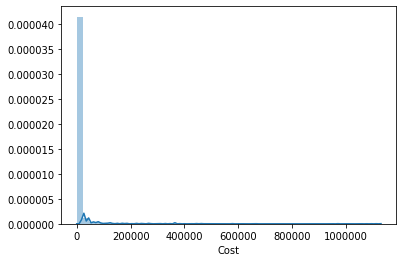

In [14]:
sns.distplot(df['Cost'])

In [15]:
df['Cost'].describe()

count    1.681100e+04
mean     7.592298e+03
std      4.009662e+04
min      0.000000e+00
25%      1.340000e+02
50%      5.690000e+02
75%      1.868000e+03
max      1.130473e+06
Name: Cost, dtype: float64

In [16]:
#skewness and kurtosis
print("Skewness: %f" % df['Cost'].skew())
print("Kurtosis: %f" % df['Cost'].kurt())

Skewness: 11.859168
Kurtosis: 187.934735


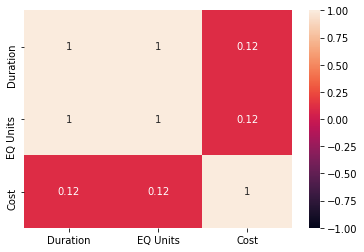

In [17]:
corr = df.corr()
sns.heatmap(corr, vmin=-1, vmax=1,annot=True,annot_kws={'size': 10})

In [18]:
#drop 'EQ Units'
df.drop(columns=['EQ Units'], inplace=True)

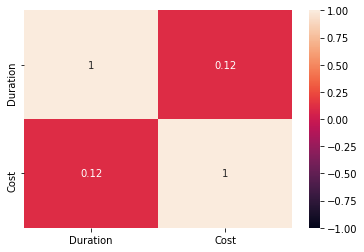

In [19]:
corr = df.corr()
sns.heatmap(corr, vmin=-1, vmax=1,annot=True,annot_kws={'size': 10})

## Check correlation among categorical variables

In [20]:
def cramers_V(var1,var2) :
    crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
    stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
    obs = np.sum(crosstab) # Number of observations
    mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
    return (stat/(obs*mini))

In [21]:
def cat_corr(df):
    label = preprocessing.LabelEncoder()
    data_encoded = pd.DataFrame() 
    cats = ['Cost','Id','Title','Brand', 'Product','Pod Position', 'Category','Network','Network Type','Show','Dayparts'
       ,'Broadcast Year','Broadcast Month','Broadcast Week','Day Of Week','Hour Of Day','TimeZone']

    for i in cats :
        data_encoded[i]=label.fit_transform(df[i])
    
    rows= []

    for var1 in data_encoded:
        col = []
        for var2 in data_encoded :
            cramers =cramers_V(data_encoded[var1], data_encoded[var2]) # Cramer's V test
            col.append(round(cramers,2)) # Keeping of the rounded value of the Cramer's V  
        rows.append(col)

    
    cramers_results = np.array(rows)
    df = pd.DataFrame(cramers_results, columns = data_encoded.columns, index =data_encoded.columns)
    return df

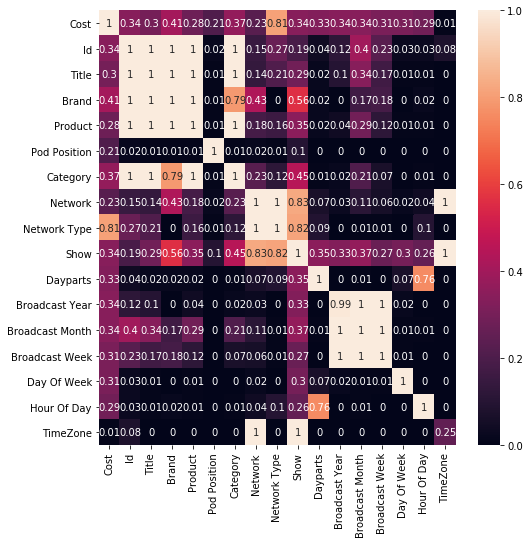

In [22]:
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(cat_corr(df), annot=True,annot_kws={'size': 10})

In [23]:
#Drop 'Id', 'Brand', 'Product', 'Category', 'Network Type', 'Broadcast Month' and 'TimeZone'
df.drop(columns=['Id','Brand', 'Product', 'Category', 'Network Type', 'TimeZone', 'Broadcast Year','Broadcast Month'], inplace=True)

In [24]:
df.head()

,Title,Network,Show,Pod Position,Dayparts,Duration,Broadcast Week,Day Of Week,Hour Of Day,Cost
0,Apple Music Bazzi,MTVU,mtvU Music Block,2,PRIME TIME,30,42,4,21,1
1,Apple iPhone 11 Pro,MLB Network,MLB Tonight,2,PRIME ACCESS,30,41,5,19,810
2,Verizon With Apple Music,ESPN Deportes,Fútbol picante,6,OVERNIGHT,30,41,1,3,6
3,Apple iPhone 11 Pro,MLB Network,MLB Tonight,2,PRIME TIME,30,41,1,20,1014
4,Verizon With Apple Music,Univision,¡Despierta América!,11,EARLY MORNING,30,40,4,8,2507


In [25]:
df['Cost_log']=np.log(df['Cost'])

## Outliers detection

(-0.5, 6.5, 0, 20)

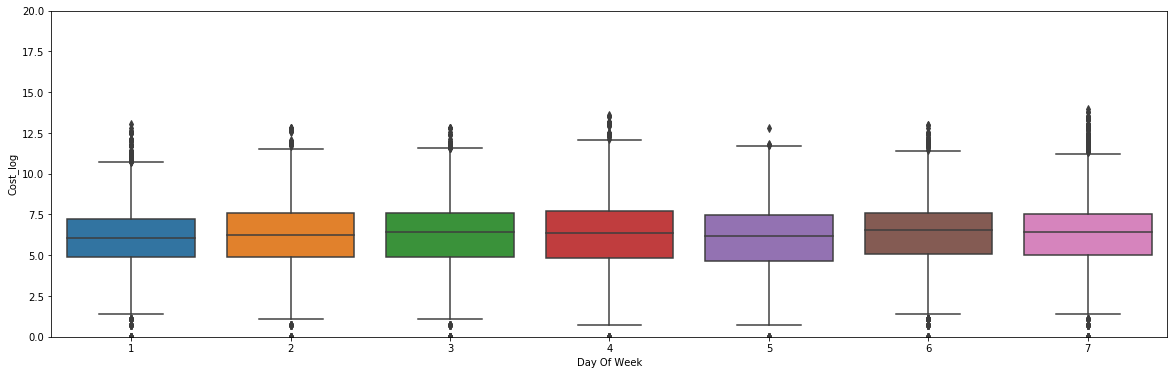

In [26]:
#box plot Day of Week/cost
var = 'Day Of Week'
data = pd.concat([df['Cost_log'], df[var]], axis=1)
f, ax = plt.subplots(figsize=(20, 6))
fig = sns.boxplot(x=var, y="Cost_log", data=data)
fig.axis(ymin=0, ymax=20)

From the above chart, I can say that no need to remove any data.

## Categorize the 'Cost' Variable : For Classification Modeling

In [27]:
Cost_cat = []
for cost in df.Cost:
    if cost < 10000:
        Cost_cat.append('Under 10k')
    elif cost<100000:
        Cost_cat.append('10k')
    elif cost<100000:
        Cost_cat.append('100k')
    else:
        Cost_cat.append('Over 100k')
df['Cost_cat'] = Cost_cat

In [28]:
df.head(3)

,Title,Network,Show,Pod Position,Dayparts,Duration,Broadcast Week,Day Of Week,Hour Of Day,Cost,Cost_log,Cost_cat
0,Apple Music Bazzi,MTVU,mtvU Music Block,2,PRIME TIME,30,42,4,21,1,0.000000,Under 10k
1,Apple iPhone 11 Pro,MLB Network,MLB Tonight,2,PRIME ACCESS,30,41,5,19,810,6.697034,Under 10k
2,Verizon With Apple Music,ESPN Deportes,Fútbol picante,6,OVERNIGHT,30,41,1,3,6,1.791759,Under 10k


## Dummy Coding

In [29]:
df_dummy = pd.get_dummies(df, columns=['Title', 'Network', 'Show', 'Pod Position','Dayparts',
                                       'Broadcast Week','Day Of Week','Hour Of Day'], drop_first=True)

In [30]:
df_dummy.shape

(16811, 1964)

In [31]:
df_dummy['Cost_log']

0         0.000000
1         6.697034
2         1.791759
3         6.921658
4         7.826842
           ...    
16806     8.157944
16807     8.567316
16808     7.660114
16809     3.465736
16810    11.599681
Name: Cost_log, Length: 16811, dtype: float64

In [32]:
delete_row = df_dummy[df_dummy["Cost_log"]==float('-inf')].index
df_dummy = df_dummy.drop(delete_row)
df_dummy = df_dummy.reset_index(drop=True)

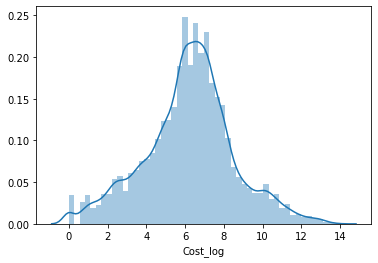

In [33]:
sns.distplot(df_dummy['Cost_log'])

## Scale

In [34]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [35]:
y = df_dummy.Cost_log
x = df_dummy.drop(columns=["Cost", "Cost_log", "Cost_cat"], axis = 1)

In [36]:
x.head()

,Duration,Title_Apple,"Title_Apple ""Share Your Gifts""",Title_Apple App Store,Title_Apple Behind The Mac,Title_Apple Card,Title_Apple HomePod,Title_Apple IPhone 11 Pro,Title_Apple IPhone 11Pro,Title_Apple Mac mini,...,Hour Of Day_21,Hour Of Day_22,Hour Of Day_23,Hour Of Day_3,Hour Of Day_4,Hour Of Day_5,Hour Of Day_6,Hour Of Day_7,Hour Of Day_8,Hour Of Day_9
0,30,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,30,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,30,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,30,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,30,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [37]:
scaler.fit(x)
scaled_x = x.copy()
scaled_x.iloc[:] = scaler.transform(x)

In [38]:
scaled_x.head()

,Duration,Title_Apple,"Title_Apple ""Share Your Gifts""",Title_Apple App Store,Title_Apple Behind The Mac,Title_Apple Card,Title_Apple HomePod,Title_Apple IPhone 11 Pro,Title_Apple IPhone 11Pro,Title_Apple Mac mini,...,Hour Of Day_21,Hour Of Day_22,Hour Of Day_23,Hour Of Day_3,Hour Of Day_4,Hour Of Day_5,Hour Of Day_6,Hour Of Day_7,Hour Of Day_8,Hour Of Day_9
0,0.654269,-0.077831,-0.024424,-0.02785,-0.071366,-0.125476,-0.025617,-0.039401,-0.041616,-0.048275,...,3.607404,-0.258544,-0.23332,-0.184466,-0.136767,-0.152452,-0.163935,-0.174558,-0.170343,-0.181333
1,0.654269,-0.077831,-0.024424,-0.02785,-0.071366,-0.125476,-0.025617,-0.039401,-0.041616,-0.048275,...,-0.277208,-0.258544,-0.23332,-0.184466,-0.136767,-0.152452,-0.163935,-0.174558,-0.170343,-0.181333
2,0.654269,-0.077831,-0.024424,-0.02785,-0.071366,-0.125476,-0.025617,-0.039401,-0.041616,-0.048275,...,-0.277208,-0.258544,-0.23332,5.421041,-0.136767,-0.152452,-0.163935,-0.174558,-0.170343,-0.181333
3,0.654269,-0.077831,-0.024424,-0.02785,-0.071366,-0.125476,-0.025617,-0.039401,-0.041616,-0.048275,...,-0.277208,-0.258544,-0.23332,-0.184466,-0.136767,-0.152452,-0.163935,-0.174558,-0.170343,-0.181333
4,0.654269,-0.077831,-0.024424,-0.02785,-0.071366,-0.125476,-0.025617,-0.039401,-0.041616,-0.048275,...,-0.277208,-0.258544,-0.23332,-0.184466,-0.136767,-0.152452,-0.163935,-0.174558,5.870520,-0.181333


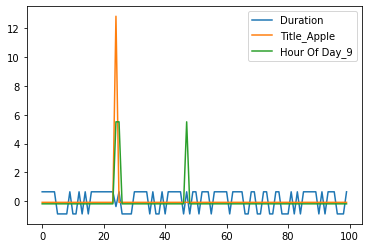

In [39]:
plt.plot(scaled_x.iloc[:100,0])
plt.plot(scaled_x.iloc[:100,1])
plt.plot(scaled_x.iloc[:100,-1])
plt.legend(['Duration ','Title_Apple ','Hour Of Day_9'])

In [40]:
x_train_scaled, x_test_scaled, y_train_scaled, y_test_scaled = train_test_split(scaled_x, y, test_size=0.2, random_state=0)

## Dimension Reduction : Principal Component Analysis

In [41]:
import sklearn.decomposition as skd
pca = skd.PCA()
pca_model=pca.fit(x_train_scaled)

### How much of the variance does each component explain?

In [42]:
pca_model.explained_variance_

array([3.65466038e+00, 3.55385631e+00, 3.53518377e+00, ...,
       1.50791711e-32, 5.54206666e-33, 5.47741381e-34])

### What would be an appropriate number of components to keep?

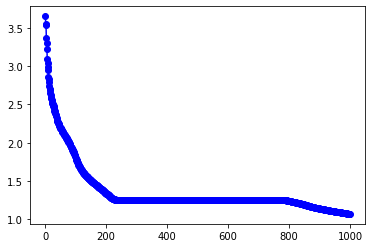

In [43]:
plt.plot(range(1,1000),pca_model.explained_variance_[:999],'b-o')

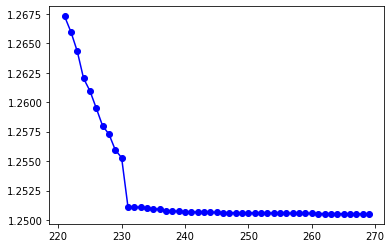

In [44]:
plt.plot(range(221,270),pca_model.explained_variance_[220:269],'b-o')

The improvements will decline, at some point rapidly, creating the elbow shape.

That point is the optimal value for K. In the image above, K=230. So, the appropriate number of components is 230.

### Exploratory Factor Analysis

In [45]:
fa_model = skd.FactorAnalysis(n_components=230).fit(x_train_scaled)

In [46]:
df_fa=pd.DataFrame(fa_model.components_[:230,:].T, 
             index=x_train_scaled.columns)

In [47]:
df_fa.head()

,0,1,2,3,4,5,6,7,8,9,...,220,221,222,223,224,225,226,227,228,229
Duration,-0.010844,3.751527e-02,-0.019079,-0.036202,9.673290e-03,2.598478e-07,-2.165501e-02,2.865276e-04,0.074064,-0.015800,...,-0.001238,0.000121,0.000105,-0.000511,-0.000394,0.000801,0.000477,0.000440,-0.001157,-0.000790
Title_Apple,-0.000232,-1.502256e-07,0.000153,-0.000100,-5.946728e-08,-9.651266e-10,-6.058388e-11,-8.417004e-11,-0.003020,-0.001017,...,0.003436,0.023004,-0.013178,0.000560,0.009498,0.035673,0.010574,-0.026743,-0.005019,0.006244
"Title_Apple ""Share Your Gifts""",-0.000065,3.274941e-08,0.000043,-0.000028,-8.198701e-09,-3.118301e-09,6.784925e-12,-5.446081e-12,-0.000848,-0.000286,...,0.000137,-0.000499,0.000846,0.000240,0.000035,0.000064,-0.000436,-0.000205,0.000027,0.000189
Title_Apple App Store,-0.000098,-2.166066e-07,0.000065,-0.000042,-1.993337e-08,2.756157e-09,1.185589e-11,-5.270092e-12,-0.001275,-0.000429,...,-0.000154,0.000029,-0.000091,-0.000092,-0.000035,-0.000138,0.000094,-0.000087,0.000050,-0.000019
Title_Apple Behind The Mac,0.016218,-7.545551e-05,0.037790,-0.075357,-8.881169e-02,-6.132565e-06,-9.925834e-02,1.313435e-03,0.075194,-0.007997,...,-0.000061,-0.000125,-0.000013,-0.000105,-0.000040,-0.000021,0.000064,0.000106,0.000126,-0.000054


In [48]:
factors = skd.FactorAnalysis(230).fit_transform(x_train_scaled)

In [49]:
df_fa_ = pd.concat([x_train_scaled, pd.DataFrame(factors)], axis=1)

In [50]:
df_fa_.head()

,Duration,Title_Apple,"Title_Apple ""Share Your Gifts""",Title_Apple App Store,Title_Apple Behind The Mac,Title_Apple Card,Title_Apple HomePod,Title_Apple IPhone 11 Pro,Title_Apple IPhone 11Pro,Title_Apple Mac mini,...,220,221,222,223,224,225,226,227,228,229
0,0.654269,-0.077831,-0.024424,-0.02785,-0.071366,-0.125476,-0.025617,-0.039401,-0.041616,-0.048275,...,-0.868340,-0.139427,0.459296,0.338968,-0.497609,-1.202685,0.867363,-1.008155,0.411617,1.048788
1,0.654269,-0.077831,-0.024424,-0.02785,-0.071366,-0.125476,-0.025617,-0.039401,-0.041616,-0.048275,...,0.343390,-0.269761,-0.429774,0.483234,-0.134657,0.788124,-0.009145,0.198880,0.167110,-0.324500
2,0.654269,-0.077831,-0.024424,-0.02785,-0.071366,-0.125476,-0.025617,-0.039401,-0.041616,-0.048275,...,0.889056,0.124352,0.613178,-0.392908,-0.185396,0.251979,0.327103,0.632294,0.718734,-0.385706
3,0.654269,-0.077831,-0.024424,-0.02785,-0.071366,-0.125476,-0.025617,-0.039401,-0.041616,-0.048275,...,0.102509,0.017443,-0.124466,-0.166534,0.126383,0.367572,0.298008,0.417727,-0.242951,0.292120
4,0.654269,-0.077831,-0.024424,-0.02785,-0.071366,-0.125476,-0.025617,-0.039401,-0.041616,-0.048275,...,0.091343,0.642451,-0.140524,-0.839803,-0.069102,0.343383,-0.139995,0.269213,0.040376,-0.003324


In [51]:
fa_cor = df_fa_.corr()[df_fa_.columns[-230:]]

In [52]:
#Extract the original variables which have the value of correlation 
#higher than 0.5 with each factor(In factor analysis model)
for c in fa_cor.columns:
    a=[]
    for i in fa_cor.index:
        if abs(fa_cor.loc[i,c])>0.5:
            a.append(i)
    print(c,a)

0 [0]
1 [1]
2 [2]
3 [3]
4 [4]
5 [5]
6 [6]
7 [7]
8 [8]
9 [9]
10 [10]
11 ['Show_A Very Vintage Christmas', 11]
12 [12]
13 [13]
14 [14]
15 [15]
16 [16]
17 [17]
18 ['Show_A Very Vintage Christmas', 18]
19 [19]
20 [20]
21 [21]
22 [22]
23 [23]
24 [24]
25 [25]
26 [26]
27 [27]
28 [28]
29 [29]
30 [30]
31 [31]
32 [32]
33 [33]
34 [34]
35 [35]
36 [36]
37 [37]
38 [38]
39 [39]
40 [40]
41 [41]
42 [42]
43 ['Show_Afternoon Bonus Coverage', 43]
44 [44]
45 [45]
46 [46]
47 [47]
48 [48]
49 [49]
50 [50]
51 [51]
52 [52]
53 [53]
54 [54]
55 [55]
56 [56]
57 [57]
58 [58]
59 [59]
60 [60]
61 [61]
62 [62]
63 [63]
64 [64]
65 [65]
66 [66]
67 [67]
68 [68]
69 [69]
70 [70]
71 [71]
72 [72]
73 [73]
74 [74]
75 [75]
76 [76]
77 [77]
78 [78]
79 [79]
80 [80]
81 [81]
82 [82]
83 [83]
84 [84]
85 [85]
86 [86]
87 [87]
88 [88]
89 [89]
90 [90]
91 [91]
92 [92]
93 [93]
94 [94]
95 [95]
96 [96]
97 [97]
98 [98]
99 [99]
100 [100]
101 [101]
102 [102]
103 [103]
104 [104]
105 [105]
106 [106]
107 [107]
108 [108]
109 [109]
110 [110]
111 [111]
1

As we can find from above, it is hard to find relationships between original features and features from EFA.

Therefore, I will use 230 as the optimal number of components for dimension reduction.

In [53]:
pca_model = skd.PCA(n_components=230).fit(x_train_scaled)
df_pca=pd.DataFrame(pca_model.components_[:230,:].T, 
             index=x_train_scaled.columns)

In [54]:
df_pca.head()

,0,1,2,3,4,5,6,7,8,9,...,220,221,222,223,224,225,226,227,228,229
Duration,0.247897,0.144095,-0.150780,-0.092450,0.010382,0.069497,0.120053,0.004212,0.031326,0.025376,...,0.000918,-0.000172,-0.005313,-0.013105,0.007728,-0.000006,-0.004799,-0.002604,0.001810,0.003096
Title_Apple,-0.008268,-0.006096,0.005450,-0.011232,0.001783,-0.003778,0.012622,0.003819,-0.002543,-0.019739,...,-0.009810,0.015143,-0.017110,-0.005010,0.018015,-0.000623,0.008157,0.013422,0.015413,0.003922
"Title_Apple ""Share Your Gifts""",0.010799,0.001449,-0.004438,-0.003844,-0.000546,0.006119,0.011262,0.003702,0.019523,-0.003155,...,0.000667,0.006481,-0.005183,0.008152,-0.005343,-0.000871,0.008065,-0.007797,0.000790,0.009790
Title_Apple App Store,-0.003239,-0.016627,0.006576,-0.003113,0.000965,-0.009546,-0.002504,-0.006109,0.003040,0.018554,...,0.000392,-0.000934,0.000542,0.001412,-0.001747,-0.000995,0.002605,-0.001297,0.003523,-0.000984
Title_Apple Behind The Mac,0.078091,0.013566,0.010427,-0.002189,-0.000666,0.063970,0.197256,-0.008488,0.445162,-0.029260,...,-0.003313,0.002874,0.000142,0.004111,0.005045,-0.004794,-0.001003,0.001897,0.001160,-0.005553


### Compressed dataset for Regression models

In [55]:
pca_train = skd.PCA(n_components=230).fit_transform(x_train_scaled)

df_pca_train=pd.DataFrame(pca_train)

pca_test = skd.PCA(n_components=230).fit_transform(x_test_scaled)

df_pca_test=pd.DataFrame(pca_test)

y_train_pca, y_test_pca = y_train_scaled, y_test_scaled

# Part 1: Regression Modeling

In [56]:
x_train_reg, x_test_reg, y_train_reg, y_test_reg = train_test_split(x, y, test_size=0.2, random_state=0)

# 1.1. Linear Regression

In [57]:
regressor = LinearRegression() 
regressor.fit(x_train_reg, y_train_reg)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### Compare the actual 'Cost' and the predicted value of 'Cost'

In [58]:
y_pred_reg = regressor.predict(x_test_reg)
df_reg = pd.DataFrame({'Actual': y_test_reg, 'Predicted': y_pred_reg})
df_reg.head(10)

,Actual,Predicted
14868,8.356555,8.537401
14301,5.863631,6.058178
9691,1.609438,2.322987
6274,4.418841,4.665562
12593,5.398163,4.647678
51,6.122493,6.311308
1963,6.167516,5.596994
11503,5.924256,6.098768
5334,4.709530,4.846249
13206,6.608001,5.984674


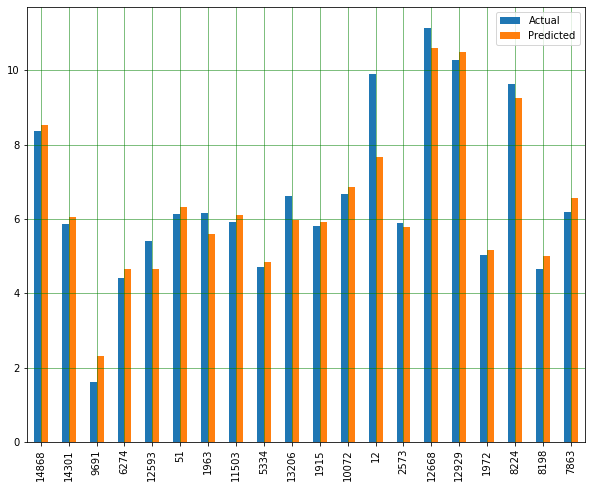

In [59]:
df1=df_reg.head(20)
df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

### Calculate the error for log-Cost

In [60]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_reg, y_pred_reg))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test_reg, y_pred_reg))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_reg, y_pred_reg)))

Mean Absolute Error: 67728373.44925758
Mean Squared Error: 4.456364949526517e+17
Root Mean Squared Error: 667560105.872611


In [61]:
for i in y_pred_reg:
    if abs(i)>1000:
        print(i)

-595541437.144928
3889978864.096199
394041589.25798416
2661878081.0866146
-7652740922.829351
270561900.03616714
6107468763.064398
6724305473.965986
6871147885.875534
-614442293.453289
3107574470.4017906
-4554405279.004637
-112574956.09597778
-107140632.55822182
-12638591956.23356
3284041052.7260303
-1849428299.7344456
2244844969.899708
1248000464.6930676
4009628669.453659
3960898833.9031467
-317038508.0424423
2209915310.3403206
2421902209.6250935
3960898833.634943
1248000464.2642689
7644048294.051365
-3624685022.388506
12968494483.594015
-7067251250.274775
2313850524.08712
-261552601.51571655
5767796920.986792
196302704.79195976
247144801.70263672
-261552602.14968872
1757989895.1304493
-939518983.125946
3284041052.575529
-112574958.47789001
-1184529310.5172367
-1184529308.1962852
9267177102.237375
1248000464.9617844
-459572.0938014984
-441542147.0744171
53718936.84970474
1797198035.4199486
-1184529310.4029198
1729903025.3965683
-4554405280.549227
1248000465.7512894
3130818859.4741707
-

In [62]:
prediction_reg = regressor.predict(x_train_reg)

Text(0.5, 1.0, 'Normal Q-Q Plot')

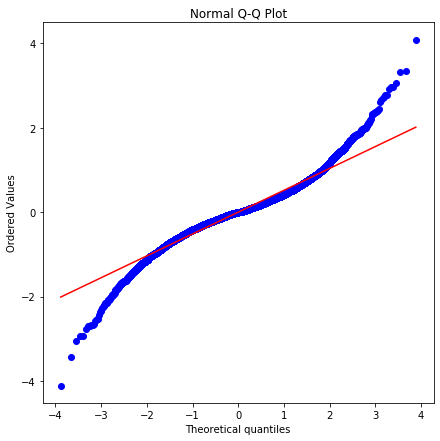

In [63]:
residuals_reg = y_train_reg - prediction_reg.reshape(-1)

plt.figure(figsize=(7,7))
stats.probplot(residuals_reg, dist="norm", plot=plt)
plt.title("Normal Q-Q Plot")

In [64]:
idx_reg=list(y_test_reg.index)

### Retransform the log transformed 'Cost' : Smear Factor

In [65]:
std_reg = statistics.stdev(y_pred_reg)
y_pred_reg_real = list(map(lambda x: math.exp(x - 0.5*std_reg**2), y_pred_reg ))
y_test_reg_real = df_dummy.Cost.iloc[idx_reg]

Since the residuals are not normally distributed, I retrandsformed using empirical method.

### Calculate the error for retransformed Cost

In [66]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_reg_real, y_pred_reg_real))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test_reg_real, y_pred_reg_real))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_reg_real, y_pred_reg_real)))

Mean Absolute Error: 7381.844411326379
Mean Squared Error: 1298638483.642325
Root Mean Squared Error: 36036.62697371002


The errorwas much bigger than I expected. 

Therefore, I plan to try some feature selection via Lasso, Ridge, and Elastic Net regression mothods

# 1.2. Lasso

In [67]:
regressor_lasso = Lasso(alpha=1.0,max_iter=1000, tol=0.0001)

In [68]:
regressor_lasso.fit(x_train_reg, y_train_reg)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

### Find coefficients for the model

In [69]:
coeff_df = pd.DataFrame(regressor_lasso.coef_, x.columns, columns=['Coefficient'])  
coeff_df

,Coefficient
Duration,0.001311
Title_Apple,0.000000
"Title_Apple ""Share Your Gifts""",-0.000000
Title_Apple App Store,-0.000000
Title_Apple Behind The Mac,-0.000000
...,...
Hour Of Day_5,-0.000000
Hour Of Day_6,-0.000000
Hour Of Day_7,-0.000000
Hour Of Day_8,-0.000000


### Compare the actual 'Cost' and the predicted value of 'Cost'

In [70]:
y_pred_lasso = regressor_lasso.predict(x_test_reg)
df_lasso = pd.DataFrame({'Actual': y_test_reg, 'Predicted': y_pred_lasso})
df_lasso.head(10)

,Actual,Predicted
14868,8.356555,6.203853
14301,5.863631,6.203853
9691,1.609438,6.223522
6274,4.418841,6.203853
12593,5.398163,6.203853
51,6.122493,6.203853
1963,6.167516,6.223522
11503,5.924256,6.203853
5334,4.709530,6.223522
13206,6.608001,6.203853


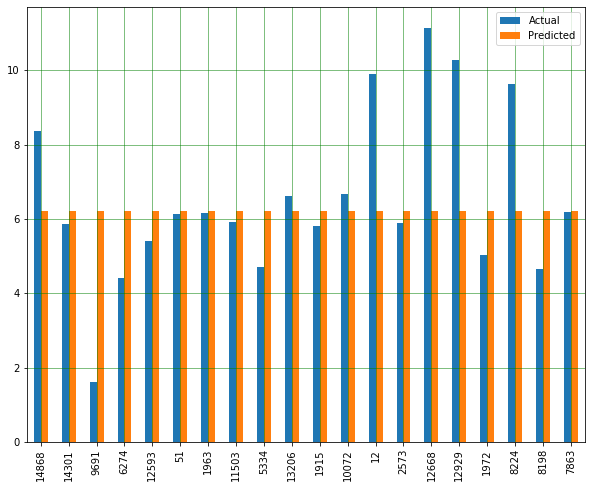

In [71]:
df1=df_lasso.head(20)
df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

### Calculate the error for log-Cost

In [72]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_reg, y_pred_lasso))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test_reg, y_pred_lasso))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_reg, y_pred_lasso)))

Mean Absolute Error: 1.7720376713572512
Mean Squared Error: 5.482713869632893
Root Mean Squared Error: 2.3415195642216813


Compare to the Linear Regression model, Lasso model has much smaller error.

In [73]:
prediction_lasso = regressor_lasso.predict(x_train_reg)

Text(0.5, 1.0, 'Normal Q-Q Plot')

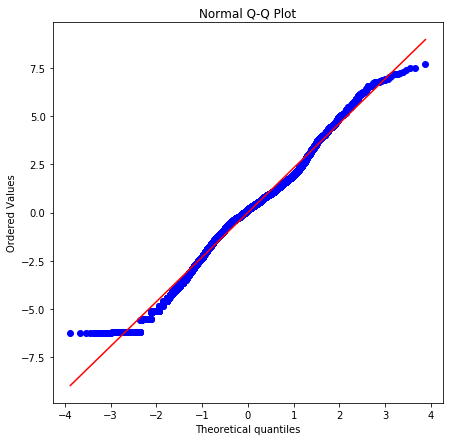

In [74]:
import scipy.stats as stats
residuals_lasso = y_train_reg - prediction_lasso.reshape(-1)

plt.figure(figsize=(7,7))
stats.probplot(residuals_lasso, dist="norm", plot=plt)
plt.title("Normal Q-Q Plot")

Residuals are nearly normally distributed.

### Retransform the log transformed 'Cost' : Smear Factor

In [75]:
std_lasso = statistics.stdev(y_pred_lasso)

In [76]:
y_pred_lasso_real = list(map(lambda x: math.exp(x + 0.5*std_lasso**2), y_pred_lasso ))

In [77]:
y_test_lasso_real = df_dummy.Cost.iloc[idx_reg]

### Calculate the error for retransformed Cost

In [78]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_lasso_real, y_pred_lasso_real))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test_lasso_real, y_pred_lasso_real))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_lasso_real, y_pred_lasso_real)))

Mean Absolute Error: 7200.879808003785
Mean Squared Error: 1291450227.3165631
Root Mean Squared Error: 35936.75315490484


# 1.3. Ridge

In [79]:
regressor_ridge = Ridge(alpha=1.0,tol=0.001, solver='auto')

In [80]:
regressor_ridge.fit(x_train_reg, y_train_reg)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

### Compare the actual 'Cost' and the predicted value of 'Cost'

In [81]:
y_pred_ridge = regressor_ridge.predict(x_test_reg)
df_ridge = pd.DataFrame({'Actual': y_test_reg, 'Predicted': y_pred_ridge})
df_ridge.head(10)

,Actual,Predicted
14868,8.356555,8.559134
14301,5.863631,6.043842
9691,1.609438,2.375957
6274,4.418841,4.841652
12593,5.398163,4.709737
51,6.122493,6.321812
1963,6.167516,5.571763
11503,5.924256,6.064882
5334,4.709530,4.855102
13206,6.608001,6.162173


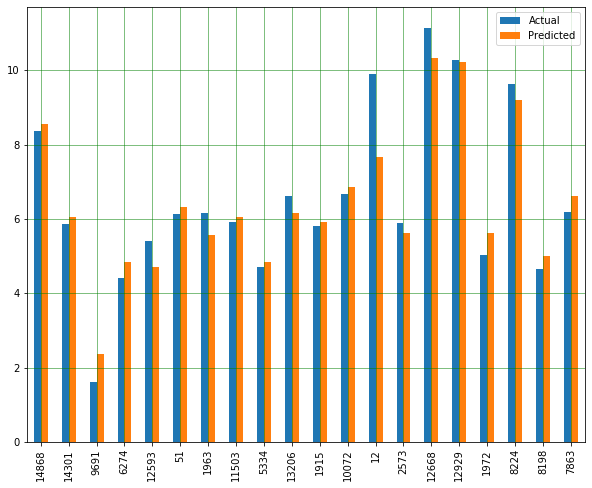

In [82]:
df1=df_ridge.head(20)
df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

### Calculate the error for log-Cost


In [83]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_reg, y_pred_ridge))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test_reg, y_pred_ridge))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_reg, y_pred_ridge)))

Mean Absolute Error: 0.439436433507422
Mean Squared Error: 0.3577669678711483
Root Mean Squared Error: 0.5981362452411225


Ridge model has a better result compare to Lasso model!

In [84]:
prediction_ridge = regressor_ridge.predict(x_train_reg)

Text(0.5, 1.0, 'Normal Q-Q Plot')

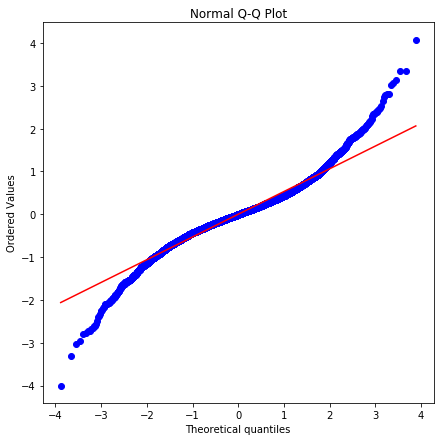

In [85]:
residuals_ridge = y_train_reg - prediction_ridge.reshape(-1)

plt.figure(figsize=(7,7))
stats.probplot(residuals_ridge, dist="norm", plot=plt)
plt.title("Normal Q-Q Plot")

The residuals from Ridge model are not normally distributed. It seems more like fat tail distribution!

Therefore, I tried emprical way to find the best result.

### Retransform the log transformed 'Cost' : Smear Factor

In [86]:
std_ridge = statistics.stdev(y_pred_ridge)
y_pred_ridge_real = list(map(lambda x: math.exp(x - 0.1*std_ridge**2), y_pred_ridge ))
y_test_ridge_real = df_dummy.Cost.iloc[idx_reg]

### Calculate the error for retransformed Cost

In [87]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_ridge_real, y_pred_ridge_real))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test_ridge_real, y_pred_ridge_real))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_ridge_real, y_pred_ridge_real)))

Mean Absolute Error: 4252.447990556186
Mean Squared Error: 476662794.6777531
Root Mean Squared Error: 21832.608517484874


# 1.4. Elastic Net

In [88]:
regressor_net = ElasticNet(alpha=1.0,l1_ratio=0.5, tol=0.0001)

In [89]:
regressor_net.fit(x_train_reg, y_train_reg)

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

### Compare the actual 'Cost' and the predicted value of 'Cost'

In [90]:
y_pred_net = regressor_net.predict(x_test_reg)
df_net = pd.DataFrame({'Actual': y_test_reg, 'Predicted': y_pred_ridge})
df_net.head(10)

,Actual,Predicted
14868,8.356555,8.559134
14301,5.863631,6.043842
9691,1.609438,2.375957
6274,4.418841,4.841652
12593,5.398163,4.709737
51,6.122493,6.321812
1963,6.167516,5.571763
11503,5.924256,6.064882
5334,4.709530,4.855102
13206,6.608001,6.162173


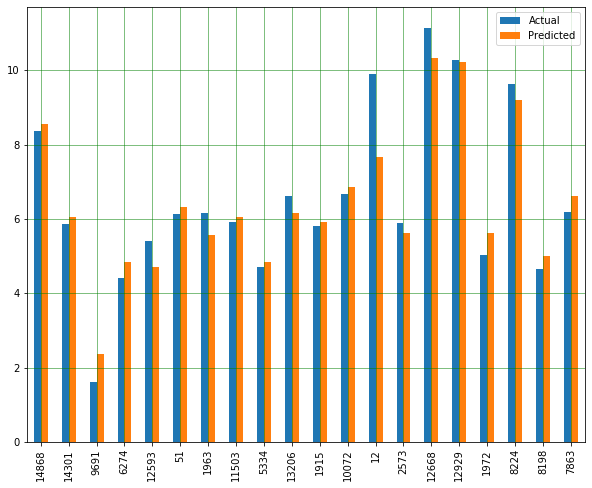

In [91]:
df1=df_net.head(20)
df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

### Calculate the error for log-Cost


In [92]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_reg, y_pred_net))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test_reg, y_pred_net))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_reg, y_pred_net)))

Mean Absolute Error: 1.7683273886320823
Mean Squared Error: 5.473750308697627
Root Mean Squared Error: 2.3396047334320444


In [93]:
prediction_net = regressor_net.predict(x_train_reg)

Text(0.5, 1.0, 'Normal Q-Q Plot')

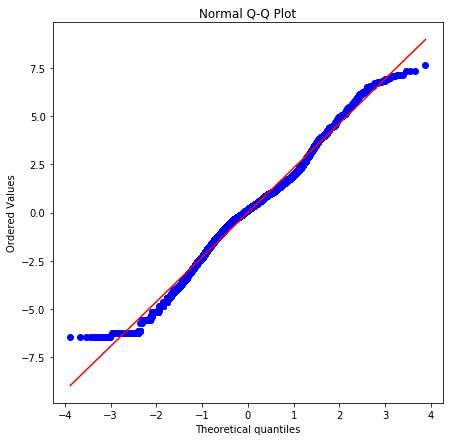

In [94]:
import scipy.stats as stats
residuals_net = y_train_reg - prediction_net.reshape(-1)

plt.figure(figsize=(7,7))
stats.probplot(residuals_net, dist="norm", plot=plt)
plt.title("Normal Q-Q Plot")

### Retransform the log transformed 'Cost' : Smear Factor


In [95]:
std_net = statistics.stdev(y_pred_net)
y_pred_net_real = list(map(lambda x: math.exp(x + 0.5*std_net**2), y_pred_net ))
y_test_net_real = df_dummy.Cost.iloc[idx_reg]

### Calculate the error for retransformed Cost

In [96]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_net_real, y_pred_net_real))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test_net_real, y_pred_net_real))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_net_real, y_pred_net_real)))

Mean Absolute Error: 7198.958675145903
Mean Squared Error: 1291209896.0248713
Root Mean Squared Error: 35933.40919012377


# 1.5. RandomForest Regression

In [97]:
train_features_reg, test_features_reg, train_labels_reg, test_labels_reg = train_test_split(x, y,
                                                                                            test_size=0.2, 
                                                                                            random_state=42)

### Train Model

In [164]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(train_features_reg, train_labels_reg)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

### Make predictions on the test sets

In [165]:
# Use the forest's predict method on the test data
predictions_rfr = rf.predict(test_features_reg)
# Calculate the absolute errors
errors = abs(predictions_rfr - test_labels_reg)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 0.36 degrees.


### Compare the actual 'Cost' and the predicted value of 'Cost'


In [166]:
df_rfr = pd.DataFrame({'Actual': test_labels_reg, 'Predicted': predictions_rfr})
df_rfr.head(10)

,Actual,Predicted
8929,0.693147,0.646111
12271,11.043322,8.502724
361,7.811163,8.171463
4296,4.007333,4.135353
8600,1.609438,1.952029
15505,5.953243,6.018184
9586,5.713733,6.473998
8977,13.531476,13.416037
16332,2.397895,2.628045
4407,4.219508,4.627275


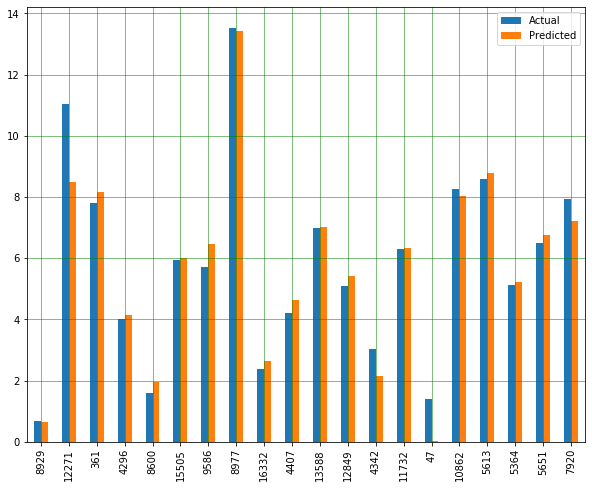

In [167]:
df1=df_rfr.head(20)
df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

### Calculate the error for log-Cost


In [168]:
print('Mean Absolute Error:', metrics.mean_absolute_error(test_labels_reg, predictions_rfr))  
print('Mean Squared Error:', metrics.mean_squared_error(test_labels_reg, predictions_rfr))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_labels_reg, predictions_rfr)))

Mean Absolute Error: 0.3591824075986763
Mean Squared Error: 0.3019103420534611
Root Mean Squared Error: 0.5494636858368905


The Random Forest Regression model has the most accurate result!

Text(0.5, 1.0, 'Normal Q-Q Plot')

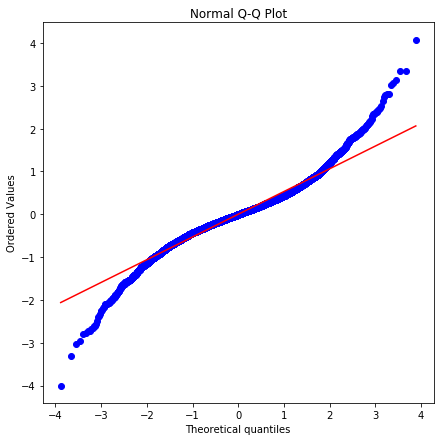

In [169]:
prediction_rfr = rf.predict(train_features_reg)
residuals_rfr = train_labels_reg - prediction_rfr.reshape(-1)

plt.figure(figsize=(7,7))
stats.probplot(residuals_ridge, dist="norm", plot=plt)
plt.title("Normal Q-Q Plot")

In [105]:
idx_rfr=list(test_labels_reg.index)

### Retransform the log transformed 'Cost' : Smear Factor


In [106]:
std_net = statistics.stdev(predictions_rfr)
predictions_rfr_real = list(map(lambda x: math.exp(x), predictions_rfr ))
test_rfr_real = df_dummy.Cost.iloc[idx_rfr]

### Calculate the error for retransformed Cost

In [107]:
print('Mean Absolute Error:', metrics.mean_absolute_error(test_rfr_real, predictions_rfr_real))  
print('Mean Squared Error:', metrics.mean_squared_error(test_rfr_real, predictions_rfr_real))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_rfr_real, predictions_rfr_real)))

Mean Absolute Error: 3303.777195838462
Mean Squared Error: 572279681.5843037
Root Mean Squared Error: 23922.367808900184


### Check the importance of each variable

In [108]:
# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(list(x.columns), importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)[:10]

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Title_Apple Music    Importance: 0.18
Variable: Dayparts_PRIME TIME  Importance: 0.13
Variable: Network_NBC          Importance: 0.05
Variable: Network_ABC          Importance: 0.04
Variable: Network_ESPN         Importance: 0.04
Variable: Network_FOX          Importance: 0.03
Variable: Network_MLB Network  Importance: 0.03
Variable: Network_MTVU         Importance: 0.03
Variable: Network_Universal Kids Importance: 0.03
Variable: Network_Universo     Importance: 0.03


# 1.5.1. Random Forest Regression with scaled data

Since the Random Forest Regression model has the best result, I just wanted to try sclaed data to predict the cost...!!

In [110]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf.fit(x_train_scaled, y_train_scaled)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [111]:
# Use the forest's predict method on the test data
predictions_rfr_sc = rf.predict(x_test_scaled)
# Calculate the absolute errors
errors = abs(predictions_rfr_sc - y_test_scaled)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 0.37 degrees.


In [112]:
df_rfr_sc = pd.DataFrame({'Actual': y_test_scaled, 'Predicted': predictions_rfr_sc})
df_rfr_sc.head(10)

,Actual,Predicted
14868,8.356555,8.371467
14301,5.863631,5.865024
9691,1.609438,2.367059
6274,4.418841,4.305681
12593,5.398163,5.413880
51,6.122493,5.869117
1963,6.167516,5.912457
11503,5.924256,6.209717
5334,4.709530,4.675784
13206,6.608001,6.723058


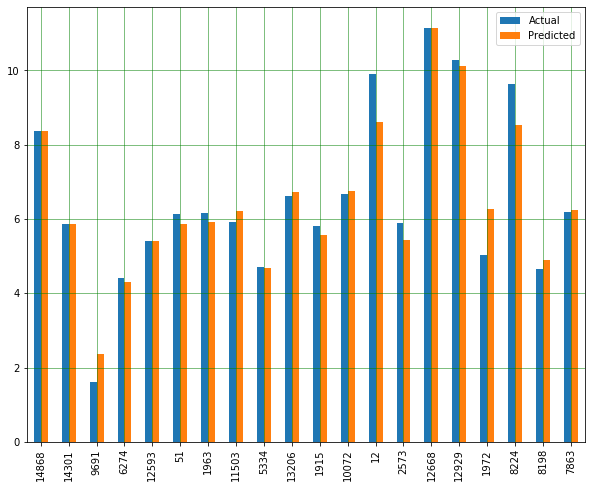

In [113]:
df1=df_rfr_sc.head(20)
df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [114]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_scaled, predictions_rfr_sc))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test_scaled, predictions_rfr_sc))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_scaled, predictions_rfr_sc)))

Mean Absolute Error: 0.36734690909473317
Mean Squared Error: 0.31330882794411674
Root Mean Squared Error: 0.5597399645765136


Unfortunately, it has worse accuracy than the Random Forest Regression model with the original dataset.

# 1.5.2. Random Forest Regression with compressed data

In [115]:
rf.fit(df_pca_train, y_train_pca)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [116]:
# Use the forest's predict method on the test data
predictions_rfr_pca = rf.predict(df_pca_test)
# Calculate the absolute errors
errors = abs(predictions_rfr_pca - y_test_pca)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 1.78 degrees.


In [117]:
df_rfr_pca = pd.DataFrame({'Actual': y_test_pca, 'Predicted': predictions_rfr_pca})
df_rfr_pca.head(10)

,Actual,Predicted
14868,8.356555,6.227566
14301,5.863631,6.677961
9691,1.609438,6.610075
6274,4.418841,6.408613
12593,5.398163,6.452462
51,6.122493,6.181679
1963,6.167516,6.444169
11503,5.924256,6.473840
5334,4.709530,6.468446
13206,6.608001,6.301751


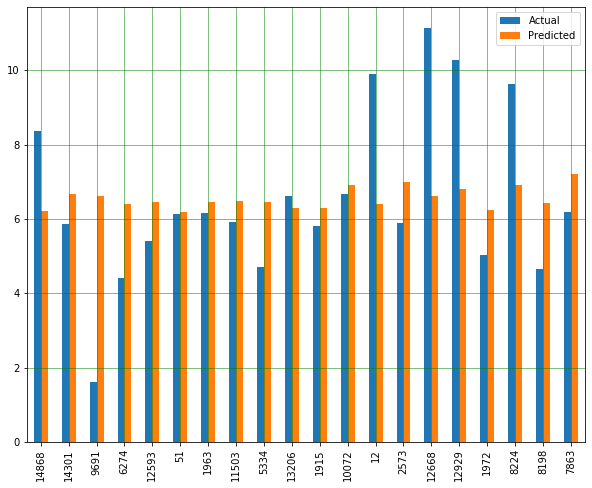

In [118]:
df1=df_rfr_pca.head(20)
df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [119]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_pca, predictions_rfr_pca))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test_pca, predictions_rfr_pca))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_pca, predictions_rfr_pca)))

Mean Absolute Error: 1.7772124291785951
Mean Squared Error: 5.515049959305365
Root Mean Squared Error: 2.3484143500041395


Unfortunately, it was worse accuracy than the Random Forest Regression model with the original dataset.

# 1.6. Gradient Boosting Regression

In [120]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

In [121]:
GBoost.fit(train_features_reg, train_labels_reg)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.05, loss='huber',
                          max_depth=4, max_features='sqrt', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=15, min_samples_split=10,
                          min_weight_fraction_leaf=0.0, n_estimators=3000,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=5, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [122]:
predictions_GBoost =GBoost.predict(test_features_reg)

In [123]:
print('Mean Absolute Error:', metrics.mean_absolute_error(test_labels_reg, predictions_GBoost))  
print('Mean Squared Error:', metrics.mean_squared_error(test_labels_reg, predictions_GBoost))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_labels_reg, predictions_GBoost)))

Mean Absolute Error: 0.4656381274503605
Mean Squared Error: 0.4541962383166755
Root Mean Squared Error: 0.6739408270142679


Worse than Random Forest Regression

# 1.7. XG Boosting Regression


In [124]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [125]:
model_xgb.fit(train_features_reg, train_labels_reg)

[15:42:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4603, gamma=0.0468,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=3,
             min_child_weight=1.7817, missing=nan, monotone_constraints='()',
             n_estimators=2200, n_jobs=-1, nthread=-1, num_parallel_tree=1,
             objective='reg:squarederror', random_state=7, reg_alpha=0.464,
             reg_lambda=0.8571, scale_pos_weight=1, silent=1, subsample=0.5213,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [126]:
predictions_xgb =model_xgb.predict(test_features_reg)

In [127]:
print('Mean Absolute Error:', metrics.mean_absolute_error(test_labels_reg, predictions_xgb))  
print('Mean Squared Error:', metrics.mean_squared_error(test_labels_reg, predictions_xgb))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_labels_reg, predictions_xgb)))

Mean Absolute Error: 0.4189600847125683
Mean Squared Error: 0.330944057823719
Root Mean Squared Error: 0.5752773746843508


XG Boosting model is better than Gradient Boosting Regression, so I tried the model with scaled data.

# 1.7.1. XG Boosting Regression with Scaled Data


In [128]:
model_xgb.fit(x_train_scaled, y_train_scaled)

[15:57:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4603, gamma=0.0468,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=3,
             min_child_weight=1.7817, missing=nan, monotone_constraints='()',
             n_estimators=2200, n_jobs=-1, nthread=-1, num_parallel_tree=1,
             objective='reg:squarederror', random_state=7, reg_alpha=0.464,
             reg_lambda=0.8571, scale_pos_weight=1, silent=1, subsample=0.5213,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [129]:
predictions_xgb_sc =model_xgb.predict(x_test_scaled)

In [130]:
print('Mean Absolute Error:', metrics.mean_absolute_error(test_labels_reg, predictions_xgb_sc))  
print('Mean Squared Error:', metrics.mean_squared_error(test_labels_reg, predictions_xgb_sc))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_labels_reg, predictions_xgb_sc)))

Mean Absolute Error: 2.547462280568252
Mean Squared Error: 10.669597030406312
Root Mean Squared Error: 3.2664349113990183


Much less accurate than XG Boosting model trained by original dataset.

# 1.8. Stacking Model

The simplest stacking approach : Averaging base models

In [131]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1) 

In [132]:
averaged_models = AveragingModels(models = (rf, GBoost, regressor_ridge, model_xgb))

In [133]:
averaged_models.fit(train_features_reg, train_labels_reg)

[16:54:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




AveragingModels(models=(RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                              criterion='mse', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=1000, n_jobs=None,
                                              oob_score=False, random_state=42,
                                              verbose...
                                     learning_rate=0.05, max_delta_step=0,
   

In [134]:
predictions_stack =averaged_models.predict(test_features_reg)

In [135]:
print('Mean Absolute Error:', metrics.mean_absolute_error(test_labels_reg, predictions_stack))  
print('Mean Squared Error:', metrics.mean_squared_error(test_labels_reg, predictions_stack))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_labels_reg, predictions_stack)))

Mean Absolute Error: 0.3946592038286984
Mean Squared Error: 0.31141984823315005
Root Mean Squared Error: 0.558050040975852


 It seems even the simplest stacking approach really improve the score compare to GBoosting method, Ridge regression, and XGboosing methods while Random Forest Regression method the most accurate model.

# Part 2: Classification

# 2.0. Data preparation for classification modeling

### Original data with dummy variables

In [136]:
y = df_dummy.Cost_cat
x = df_dummy.drop(columns=["Cost", "Cost_log", "Cost_cat"], axis = 1)
train_features_cl, test_features_cl, train_labels_cl, test_labels_cl = train_test_split(x, y,
                                                                                test_size=0.2, random_state=0)

### Scaled data

In [137]:
scaler.fit(x)
scaled_x = x.copy()
scaled_x.iloc[:] = scaler.transform(x)

In [138]:
x_train_scaled, x_test_scaled, y_train_scaled, y_test_scaled = train_test_split(scaled_x, y, test_size=0.2, random_state=0)

### Compressed data

In [139]:
pca_train = skd.PCA(n_components=230).fit_transform(x_train_scaled)
df_pca_train=pd.DataFrame(pca_train)

In [140]:
pca_test = skd.PCA(n_components=230).fit_transform(x_test_scaled)
df_pca_test=pd.DataFrame(pca_test)
y_train_pca, y_test_pca = y_train_scaled, y_test_scaled

# 2.1. Random Forest Classification

In [141]:
import sklearn.ensemble as skens
rf_model = skens.RandomForestClassifier(n_estimators=1000,oob_score=True, criterion='entropy')
rf_model.fit(train_features_cl,train_labels_cl)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [142]:
predicted_labels = rf_model.predict(test_features_cl)
label_rf1 = pd.DataFrame(test_labels_cl).copy()
label_rf1['predicted_rf_tree'] = predicted_labels

In [143]:
label_rf1

,Cost_cat,predicted_rf_tree
14868,Under 10k,Under 10k
14301,Under 10k,Under 10k
9691,Under 10k,Under 10k
6274,Under 10k,Under 10k
12593,Under 10k,Under 10k
...,...,...
7576,Under 10k,Under 10k
1098,10k,10k
9937,Under 10k,Under 10k
6918,Under 10k,Under 10k


In [144]:
def accuracy(predicted_labels, test_labels):
    i=0
    for l in range(len(predicted_labels)):
        if predicted_labels[l]==list(test_labels)[l]:
            i+=1
    return i/len(predicted_labels)*100

In [147]:
print("Accuracy of the Random Forest Calssification model is : ", accuracy(predicted_labels,label_rf1['Cost_cat']),"%")

Accuracy of the Random Forest Calssification model is :  96.84053651266767 %


## Random Forest Classification with compressed data

In [148]:
rf_model.fit(df_pca_train,y_train_pca)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [149]:
predicted_labels_pca = rf_model.predict(df_pca_test)

In [150]:
print("Accuracy of the Random Forest Calssification model is : ", accuracy(predicted_labels_pca,y_test_pca),"%")

Accuracy of the Random Forest Calssification model is :  90.52160953800298 %


## Random Forest Classification with Scaled Data

In [151]:
rf_model.fit(x_train_scaled,y_train_scaled)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [152]:
predicted_labels_sc = rf_model.predict(x_test_scaled)

In [153]:
print("Accuracy of the Random Forest Calssification model is : ", accuracy(predicted_labels_sc,y_test_scaled),"%")

Accuracy of the Random Forest Calssification model is :  96.87034277198212 %


# 2.2. KNN Classification

In [154]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(train_features_cl, train_labels_cl)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [155]:
predicted_labels_Knn = classifier.predict(test_features_cl)

In [156]:
print("Accuracy of the KNN Calssification model is : ", accuracy(predicted_labels_Knn,test_labels_cl),"%")

Accuracy of the KNN Calssification model is :  95.70789865871832 %


### KNN Classification With Scaled Data

In [157]:
classifier.fit(x_train_scaled, y_train_scaled)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [158]:
predicted_labels_Knn_sc = classifier.predict(x_test_scaled)

In [159]:
print("Accuracy of the KNN Calssification model is : ", accuracy(predicted_labels_Knn_sc,test_labels_cl),"%")

Accuracy of the KNN Calssification model is :  96.15499254843517 %


### KNN Classification With Compressed Data

In [160]:
classifier.fit(df_pca_train, y_train_pca)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [161]:
predicted_labels_Knn_pca = classifier.predict(df_pca_test)

In [162]:
print("Accuracy of the KNN Calssification model is : ", accuracy(predicted_labels_Knn_pca,y_test_pca),"%")

Accuracy of the KNN Calssification model is :  89.74664679582712 %


# 2.2. Logistic Regression

In [172]:
classifier = LogisticRegression(solver='liblinear', C=0.05, multi_class='ovr',
                           random_state=0, n_jobs=-1)
classifier.fit(train_features_cl, train_labels_cl)

LogisticRegression(C=0.05, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=-1, penalty='l2', random_state=0,
                   solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [173]:
predicted_labels_log = classifier.predict(test_features_cl)

In [176]:
print("Accuracy of the Logistic Regression Calssification model is : ", accuracy(predicted_labels_log,test_labels_cl),"%")

Accuracy of the Logistic Regression Calssification model is :  95.0521609538003 %


## Logistic Regression with Scaled Data

In [177]:
classifier.fit(x_train_scaled, y_train_scaled)

LogisticRegression(C=0.05, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=-1, penalty='l2', random_state=0,
                   solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [178]:
predicted_labels_log_sc = classifier.predict(x_test_scaled)

In [179]:
print("Accuracy of the Logistic Regression Calssification is : ", accuracy(predicted_labels_log_sc,test_labels_cl),"%")

Accuracy of the Logistic Regression Calssification is :  94.93293591654248 %


## Logistic Regression with Compressed Data

In [180]:
classifier.fit(df_pca_train, y_train_pca)
predicted_labels_log_pca = classifier.predict(df_pca_test)

In [182]:
print("Accuracy of the Logistic Regression Calssification model is : ", accuracy(predicted_labels_log_pca,y_test_pca),"%")

Accuracy of the Logistic Regression Calssification model is :  88.13710879284649 %
